In [88]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

# Deep Neural Networks 

## Moons and Decision boundary

## Import Statements

In [89]:
###-----------------
### Import libraries
###-----------------
from pathlib import Path  # Import Path for file system path operations and management
import numpy as np  # Import NumPy for numerical computations and array operations
import pandas as pd  # Import Pandas for data manipulation and analysis with DataFrames
import matplotlib.pyplot as plt  # Import Matplotlib for creating static, interactive visualizations
import seaborn as sns  # Import Seaborn for statistical data visualization built on Matplotlib
from sklearn.datasets import make_moons, make_circles
from sklearn.model_selection import train_test_split  # Import function to split dataset into training and testing subsets
from sklearn.metrics import (accuracy_score, 
                             classification_report, 
                             confusion_matrix, 
                             ConfusionMatrixDisplay, 
                             f1_score)  # Import function to calculate various metric
from sklearn.preprocessing import StandardScaler,LabelEncoder
import tensorflow as tf
import sys
import torch
import torch.nn as nn
from torchsummary import summary

# import helper as hp

In [90]:
def fn_plot_confusion_matrix(y_true, y_pred, labels):
    '''
    Args:
        y_true: Ground Truth
        y_pred : Predictions
        labels : labels in a dictonary
                  {0: 'Goal Keeper',
                  1: 'Defender',
                  2: 'Mid-Fielder',
                  3: 'Forward'}

    '''

    cm  = confusion_matrix(y_true, y_pred)

    if isinstance(labels, dict):
        display_labels = labels.values()
    else:
        display_labels = labels

    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=display_labels)

    fig, ax = plt.subplots(figsize = (4,4))

    disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

    # Disable the grid
    ax.grid(False)

    plt.show()


In [91]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [92]:
###------------------
### Global Parameters
###------------------

# # Directories
# #inpDir = '../../input'
# inpDir = Path('..') / '..' / 'input'
# # outDir = '../output'
# outDir = Path('..') / 'output'


RANDOM_STATE = 42
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE)
# rng=np.random.default_rng(seed=RANDOM_STATE)
TEST_SIZE  = 0.2 # Size of test data

# Parameters for plotting
NOISE=0.2
EPOCHS=100
ALPHA=0.001
N_SAMPLE=1000

params = {'legend.fontsize': 'medium',
          'figure.figsize': (15, 6),
          'axes.labelsize': 'large',
          'axes.titlesize':'large',
          'xtick.labelsize':'medium',
          'ytick.labelsize':'medium'
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params)

plt.style.use('seaborn-v0_8-darkgrid') # plt.style.use('ggplot')

In [93]:
data_df=pd.read_csv("Wine.csv")
data_df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,target
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [94]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   alcohol                       178 non-null    float64
 1   malic_acid                    178 non-null    float64
 2   ash                           178 non-null    float64
 3   alcalinity_of_ash             178 non-null    float64
 4   magnesium                     178 non-null    float64
 5   total_phenols                 178 non-null    float64
 6   flavanoids                    178 non-null    float64
 7   nonflavanoid_phenols          178 non-null    float64
 8   proanthocyanins               178 non-null    float64
 9   color_intensity               178 non-null    float64
 10  hue                           178 non-null    float64
 11  od280/od315_of_diluted_wines  178 non-null    float64
 12  proline                       178 non-null    float64
 13  targe

In [95]:
data_df.describe().T


,count,mean,std,min,25%,50%,75%,max
alcohol,178.0,13.000618,0.811827,11.03,12.3625,13.050,13.6775,14.83
malic_acid,178.0,2.336348,1.117146,0.74,1.6025,1.865,3.0825,5.80
ash,178.0,2.366517,0.274344,1.36,2.2100,2.360,2.5575,3.23
alcalinity_of_ash,178.0,19.494944,3.339564,10.60,17.2000,19.500,21.5000,30.00
magnesium,178.0,99.741573,14.282484,70.00,88.0000,98.000,107.0000,162.00
total_phenols,178.0,2.295112,0.625851,0.98,1.7425,2.355,2.8000,3.88
flavanoids,178.0,2.029270,0.998859,0.34,1.2050,2.135,2.8750,5.08
nonflavanoid_phenols,178.0,0.361854,0.124453,0.13,0.2700,0.340,0.4375,0.66
proanthocyanins,178.0,1.590899,0.572359,0.41,1.2500,1.555,1.9500,3.58
color_intensity,178.0,5.058090,2.318286,1.28,3.2200,4.690,6.2000,13.00


In [96]:
for col in data_df.columns:
    print(f"Column: {col}-{data_df[col].unique()}")

Column: alcohol-[14.23 13.2  13.16 14.37 13.24 14.2  14.39 14.06 14.83 13.86 14.1  14.12
 13.75 14.75 14.38 13.63 14.3  13.83 14.19 13.64 12.93 13.71 12.85 13.5
 13.05 13.39 13.3  13.87 14.02 13.73 13.58 13.68 13.76 13.51 13.48 13.28
 13.07 14.22 13.56 13.41 13.88 14.21 13.9  13.94 13.82 13.77 13.74 13.29
 13.72 12.37 12.33 12.64 13.67 12.17 13.11 13.34 12.21 12.29 13.49 12.99
 11.96 11.66 13.03 11.84 12.7  12.   12.72 12.08 12.67 12.16 11.65 11.64
 12.69 11.62 12.47 11.81 12.6  12.34 11.82 12.51 12.42 12.25 12.22 11.61
 11.46 12.52 11.76 11.41 11.03 12.77 11.45 11.56 11.87 12.07 12.43 11.79
 12.04 12.86 12.88 12.81 12.53 12.84 13.36 13.52 13.62 12.87 13.32 13.08
 12.79 13.23 12.58 13.17 13.84 12.45 14.34 12.36 13.69 12.96 13.78 13.45
 12.82 13.4  12.2  14.16 13.27 14.13]
Column: malic_acid-[1.71 1.78 2.36 1.95 2.59 1.76 1.87 2.15 1.64 1.35 2.16 1.48 1.73 1.81
 1.92 1.57 1.59 3.1  1.63 3.8  1.86 1.6  2.05 1.77 1.72 1.9  1.68 1.5
 1.66 1.83 1.53 1.8  1.65 3.99 3.84 1.89 3.98 4.04 3.59 2

In [97]:
data_df.isna().sum()

alcohol                         0
malic_acid                      0
ash                             0
alcalinity_of_ash               0
magnesium                       0
total_phenols                   0
flavanoids                      0
nonflavanoid_phenols            0
proanthocyanins                 0
color_intensity                 0
hue                             0
od280/od315_of_diluted_wines    0
proline                         0
target                          0
dtype: int64

<Axes: >

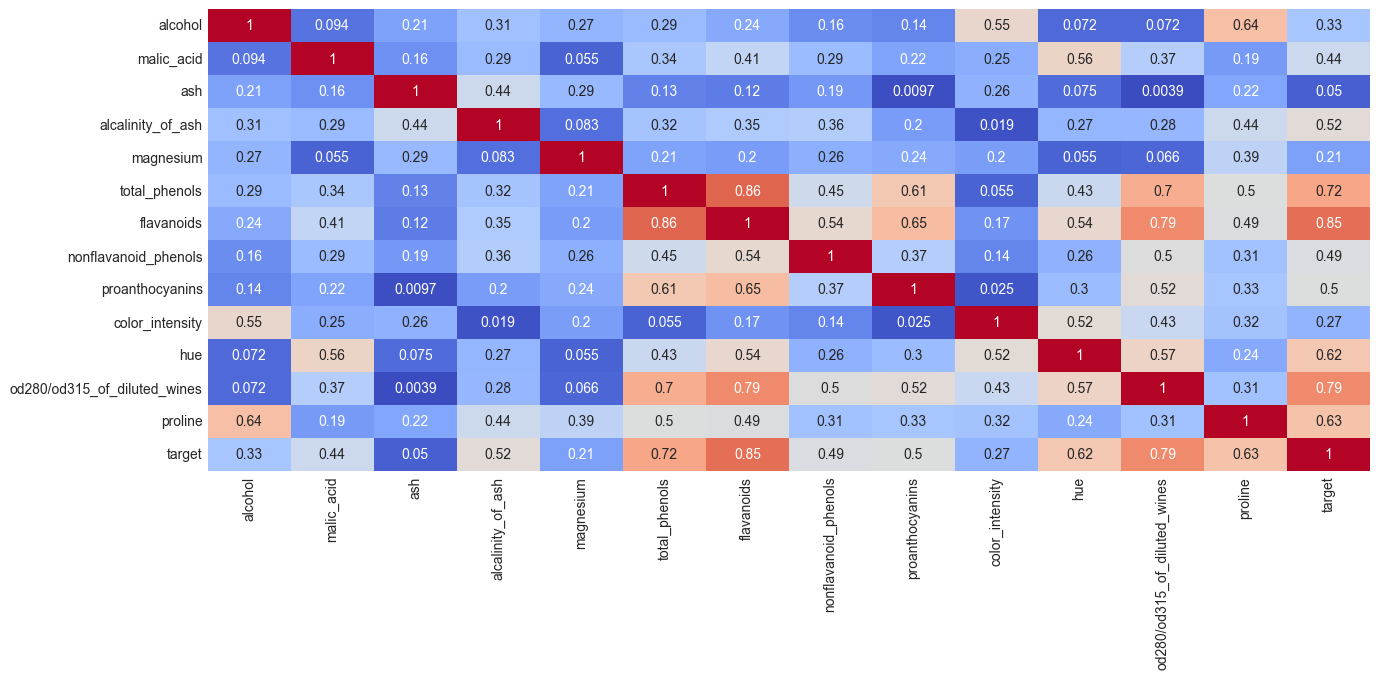

In [98]:
fig,ax=plt.subplots()
sns.heatmap(data_df.corr().abs(),ax=ax,fmt=".2g", annot=True, cmap=CMAP,cbar=False)

In [99]:
labels=data_df[data_df.columns[-1]]
features_df=data_df.drop(data_df.columns[-1],axis=1)
features_df.shape,labels.shape

((178, 13), (178,))

In [100]:
X_train, X_test, y_train, y_test = train_test_split(features_df,labels, test_size=TEST_SIZE, random_state=RANDOM_STATE, stratify=labels)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142, 13), (36, 13), (142,), (36,))

In [101]:


ss=StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [102]:
le=LabelEncoder()
y_train=le.fit_transform(y_train)
y_test=le.transform(y_test)

DEFINE MODELS

In [103]:
model=nn.Sequential(
    nn.Linear(13,8),
    nn.ReLU(),
    nn.Linear(8,3)

)
display(model)

Sequential(
  (0): Linear(in_features=13, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=3, bias=True)
)

In [104]:
print(model)

Sequential(
  (0): Linear(in_features=13, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=3, bias=True)
)


In [105]:
# functional API

# inputs=tf.keras.Input(shape=(X_train.shape[1],))
# x=tf.keras.layers.Dense(8,activation='relu')(inputs)
# outputs=tf.keras.layers.Dense(3)(x)
# model1=tf.keras.Model(inputs=inputs,outputs=outputs)

In [106]:
# print(model1)

In [107]:
loss_fn=nn.CrossEntropyLoss()   #Combination of loss of Classification and loss of softmax
optimizer=torch.optim.Adam(model.parameters(),lr=ALPHA)

In [108]:
#(torch)            (numpy)
train_X=torch.tensor(X_train,dtype=torch.float32,device=device)
test_X=torch.tensor(X_test,dtype=torch.float32,device=device)
train_y=torch.tensor(y_train,dtype=torch.int64,device=device)
test_y=torch.tensor(y_test,dtype=torch.int64,device=device)

UNIT TEST

In [109]:
pred=model(train_X[:1])
pred

tensor([[ 0.2188, -0.0188,  0.0017]], grad_fn=<AddmmBackward0>)

In [110]:
loss_fn(pred,train_y[:1])       #Neural network log loss designed for back ptopagation

tensor(0.9529, grad_fn=<NllLossBackward0>)

In [111]:
loss_fn(pred,train_y[:1]).item()

0.9529355764389038

PERFORMING ON TRAINING DATA


In [112]:
train_loss,test_loss=[],[]
train_accuracy,test_accuracy=[],[]
for epoch in range(EPOCHS):
    model.train()
    outputs=model(train_X)
    loss=loss_fn(outputs,train_y)
                                                #first 6 lines to optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())
    _,y_pred=torch.max(outputs,1)
    curr_acc=accuracy_score(y_train,y_pred.data.cpu())
    train_accuracy.append(curr_acc)
    with torch.no_grad():                       #working with testing
        model.eval()                            #Switch off the layers that helped in training
        outputs=model(test_X)
        tloss=loss_fn(outputs,test_y)
        test_loss.append(tloss.item())
        _,y_pred=torch.max(outputs,1)
        tcurr_acc=accuracy_score(y_test,y_pred.data.cpu())
        test_accuracy.append(tcurr_acc)
    if epoch%10==0:
        print(f"Epoch: {epoch}-loss:{loss.item():.4f}-{tloss.item():.4f}")

Epoch: 0-loss:1.2156-1.2097
Epoch: 10-loss:1.1688-1.1642
Epoch: 20-loss:1.1274-1.1227
Epoch: 30-loss:1.0888-1.0831
Epoch: 40-loss:1.0535-1.0453
Epoch: 50-loss:1.0183-1.0078
Epoch: 60-loss:0.9834-0.9714
Epoch: 70-loss:0.9496-0.9360
Epoch: 80-loss:0.9165-0.9018
Epoch: 90-loss:0.8831-0.8696


In [119]:
loss_df=pd.DataFrame({'epoch':range(EPOCHS), 'loss': train_loss, 'test_loss': test_loss, 'accuracy': train_accuracy, 'test accuracy': test_accuracy})

In [120]:
loss_df.head()

,epoch,loss,test_loss,accuracy,test accuracy
0,0,1.215634,1.209750,0.330986,0.333333
1,1,1.210656,1.205027,0.330986,0.333333
2,2,1.205738,1.200223,0.330986,0.333333
3,3,1.200908,1.195467,0.330986,0.333333
4,4,1.196162,1.190830,0.330986,0.333333


In [121]:
def fn_plot_torch_hist(hist_df):

    # instantiate figure
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch
    props = dict(boxstyle='round', facecolor='cyan', alpha=0.5)

    # columns
    x = hist_df.columns[0]
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[2]
    y3 = hist_df.columns[3]
    y4 = hist_df.columns[4]

    # Where was min loss
    best = hist_df[hist_df[y2] == hist_df[y2].min()]
    best = best.drop_duplicates(subset='test_loss')
    # pick first axis
    ax = axes[0]

    # Plot all losses
    hist_df.plot(x = x, y = [y1, y2], ax = ax)

    # calculate offset for arroe
    y_min = min(hist_df[y1].min(), hist_df[y2].min())
    y_max = max(hist_df[y1].max(), hist_df[y2].max())
    offset = (y_max-y_min)/10.0

    # little beautification
    txtFmt = "Loss: \n  train: {:6.4f}\n   test: {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y1],
                           hist_df.iloc[-1][y2]) #text to plot

    # place a text box in upper middle in axes coords
    ax.text(0.3, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Min: {best[y2].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y2].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()+ offset, best[y2].to_numpy()[0]+offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow

    # Draw vertical line at best value
    ax.axvline(x = best[x].to_numpy(), color = 'green', linestyle='-.', lw = 3);

    ax.set_xlabel(x.title())
    ax.set_ylabel(y1.title())
    ax.set_title('Errors')
    ax.grid(True)
    ax.legend(loc = 'upper left') # model legend to upper left

    # pick second axis
    ax = axes[1]

    # Plot accuracies
    hist_df.plot(x = x, y = [y3, y4], ax = ax)

    # little beautification
    txtFmt = "Accuracy: \n  train: {:6.4f}\n  test:  {:6.4f}"
    txtstr = txtFmt.format(hist_df.iloc[-1][y3],
                           hist_df.iloc[-1][y4]) #text to plot

    # calculate offset for arroe
    y_min = min(hist_df[y3].min(), hist_df[y4].min())
    y_max = max(hist_df[y3].max(), hist_df[y4].max())
    offset = (y_max-y_min)/10.0

    # place a text box in lower middle in axes coords
    ax.text(0.3, 0.2, txtstr, transform=ax.transAxes, fontsize=12,
            verticalalignment='top', bbox=props)

    # Mark arrow at lowest
    ax.annotate(f'Best: {best[y4].to_numpy()[0]:6.4f}', # text to print
                xy=(best[x].to_numpy(), best[y4].to_numpy()[0]), # Arrow start
                xytext=(best[x].to_numpy()- offset, best[y4].to_numpy()[0]-offset), # location of text
                fontsize=14,va='bottom', ha='right',bbox=props, # beautification of text
                arrowprops=dict(facecolor='cyan', shrink=0.05)) # arrow


    # Draw a vertical line at best value
    ax.axvline(x = best[x].to_numpy(),
               color = 'green',
               linestyle='-.', lw = 3)

    # Labels
    ax.set_xlabel(x.title())
    ax.set_ylabel(y3.title())
    ax.set_title('Accuracies')
    ax.grid(True)
    ax.legend(loc = 'lower left')

    plt.tight_layout()

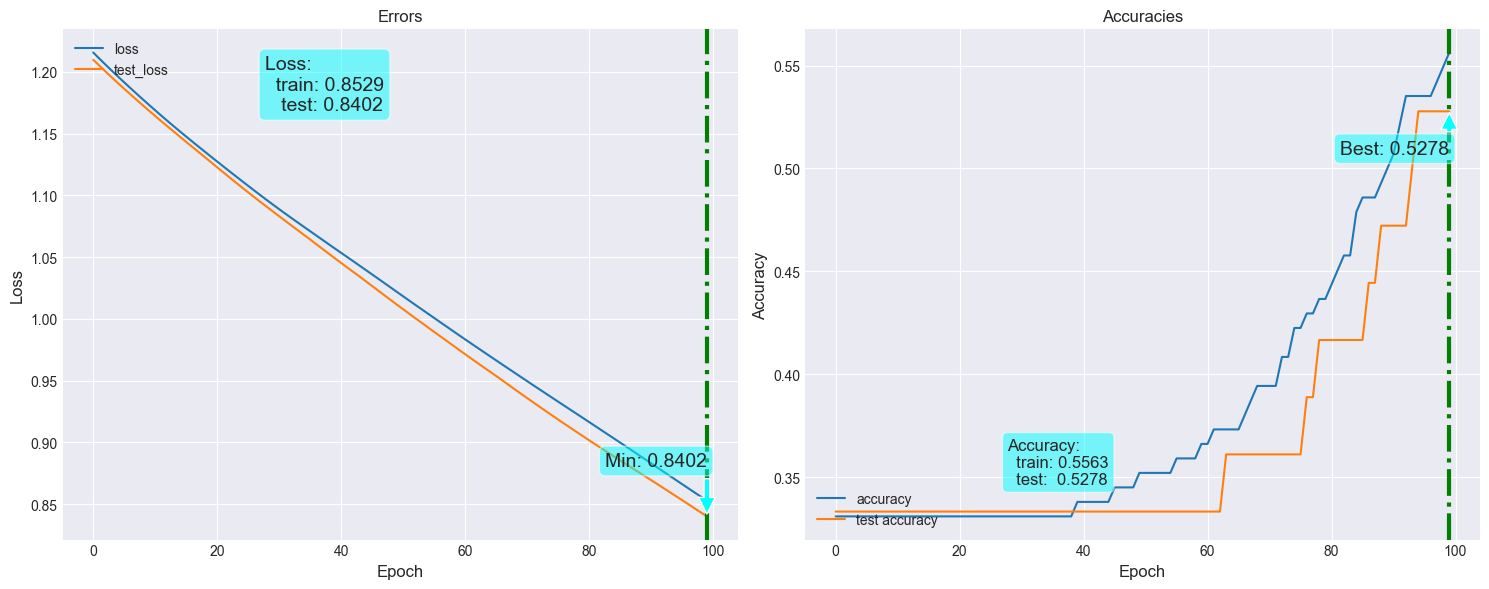

In [122]:
fn_plot_torch_hist(loss_df)

In [124]:
summary(model.to(device=device),)

TypeError: Value after * must be an iterable, not int

Tells us about the parameter of the first weight

In [125]:
len(list(model.parameters()))
list(model.parameters())[1].shape

torch.Size([8])

Evaluation

In [50]:
model.eval()
with torch.no_grad():
    train_pred=model(train_X)
    test_pred=model(test_X)

type(train_pred),type(test_pred)

(torch.Tensor, torch.Tensor)

In [53]:
y_train_pred=train_pred.detach().cpu().numpy()
y_train_pred=y_train_pred.argmax(axis=1)
type(y_train_pred)

numpy.ndarray

In [56]:
class_names={}
for i,cl in enumerate(le.classes_):
    class_names[i]=cl
class_names

{0: np.int64(0), 1: np.int64(1), 2: np.int64(2)}

PREDICTIONS

In [57]:
#y_pred=prob_model(X_train).numpy()
print(f"Accuracy: {accuracy_score(y_train,y_train_pred):.4f}%")
print(classification_report(y_train,y_train_pred))

Accuracy: 0.8732%
              precision    recall  f1-score   support

           0       0.84      1.00      0.91        47
           1       1.00      0.68      0.81        57
           2       0.81      1.00      0.89        38

    accuracy                           0.87       142
   macro avg       0.88      0.89      0.87       142
weighted avg       0.90      0.87      0.87       142



In [58]:
print(confusion_matrix(y_train,y_train_pred))

[[47  0  0]
 [ 9 39  9]
 [ 0  0 38]]


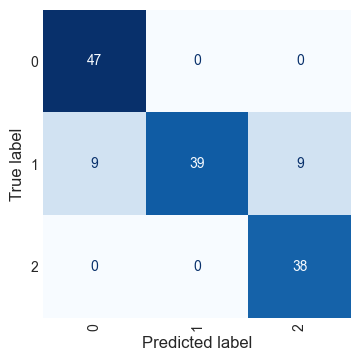

In [60]:

fn_plot_confusion_matrix(y_train,y_train_pred,labels=class_names)

PERFORMING ON TESTING DATA


Performance on TEST

In [ ]:
for epoch in range(EPOCHS):
    model.train()
    outputs=model(test_X)
    loss=loss_fn(outputs,train_y)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if epoch%10==0:
        print(f"Epoch: {epoch}-loss:{loss.item():.4f}")

In [ ]:
model.eval()
with torch.no_grad():
    test_pred=model(train_X)
    test_pred=model(test_X)

type(train_pred),type(test_pred)